# Homework 9
**Total Points: 5**

**Instructions:**
1. Complete parts 1 through 5, filling in code or responses where marked with `# YOUR CODE HERE` or `# YOUR ANALYSIS HERE`.
2. The libraries you need have already been coded. Do not import additional libraries or move import commands.
3. When finished, run the full notebook by selecting <b>Kernel > Restart & Run All</b>. </li>
4. Submit this completed notebook file to <b>NYU Classes</b>. </li>**(Important: Only submit your .ipynb file! Do not submit the entire dataset.)**

In this assignment you will test several different techniques to estimate chords and chord progressions over time of *polyphonic* audio signals.

**Grading:** Each part is worth 1 point.

Download and extract both the audio files and the chord label data, which are both included in **Homework-9.zip**.  The folder stucture should be:

`
 <--   Homework-9.ipynb
 <--   chords
 |     <--   *.txt files      
 <--   audio 
 |     <--   *.wav files
`

The `*.wav` audio files contain recordings of different songs. Each audio file has a matching filename `*.txt`, which contains ground truth chord labels and chord intervals (times in seconds).

In [1]:
import numpy as np
import librosa
import IPython
import IPython.display as ipd
import mir_eval
from mir_eval.sonify import chords
from mir_eval.display import segments
import madmom
from madmom.audio.chroma import DeepChromaProcessor
from madmom.features.chords import DeepChromaChordRecognitionProcessor

## Helpers: Chord Template, `get_truth()`, and  `view_template()`

The following cell will generate templates that will identify major and minor chords. Each row in `chroma_template` corresponds to the chord name in the index of `chord_label`. For example:

`
chroma_template[14] = [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
chord_labels[14] = "D:min"
`

Each column in the template corresponds to one pitch class, starting with C. If the value is 1 for that pitch class, then that pitch class is contained in that chord (otherwise the value is 0. If you want to visualize the chord templates and their corresponding chord names, run the function `view_template()`.

In [2]:
chord_root = np.array(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B'], dtype='<U12')
chord_labels = np.array([], dtype='<U12')
chroma_template = np.zeros([12,12])

# MAJOR/MINOR

chord_labels = np.append(chord_root,chord_root)
chroma_template = np.append(chroma_template, chroma_template, axis=0)
majorTriad = np.array([0,4,7])
minorTriad = np.array([0,3,7])

for i in range(0,12):
    chroma_template[i,np.mod(majorTriad[0],12)] = 1
    chroma_template[i,np.mod(majorTriad[1],12)] = 1
    chroma_template[i,np.mod(majorTriad[2],12)] = 1
    chord_labels[i] = chord_root[i] + ":maj"
    majorTriad += 1
for i in range(12,24):
    chroma_template[i,np.mod(minorTriad[0],12)] = 1
    chroma_template[i,np.mod(minorTriad[1],12)] = 1
    chroma_template[i,np.mod(minorTriad[2],12)] = 1
    chord_labels[i] = chord_root[int(np.mod(i,12))] + ":min"
    minorTriad += 1

def view_template():
    """ prints the chord template
    
    Parameters
    ----------
    None
    
    Returns
    -------
    None
    
    """
    
    for i in range(chroma_template.shape[0]):
        print(str([i]) + " - " + str(chord_labels[i]))


def get_truth(filepath):
    """ gets the truth chord data from filepath
    
    Parameters
    ----------
    filepath : str
        Path to text file with chord truth data
    
    Returns
    -------
    chord_intervals : np.ndarray, shape=(n, 2)
        Chord intervals [start_time, end_time] in seconds
    chord_labels : list, shape=(n,)
        List of chord labels, e.g. ['A:maj', 'G:min', ...]
    
    """
    
    chord_intervals = np.zeros([0,2])
    chord_labels = np.array([])
    f = open(filepath, 'r')
    gt = f.readlines()

    for rl in gt:
        i = rl.split(',')
        chord_intervals = np.vstack([chord_intervals,[float(i[0]),float(i[1])]])
        chord_labels = np.append(chord_labels,i[2].strip())
    return chord_intervals, chord_labels

In [3]:
# UNCOMMENT TO VIEW THE CHORD TEMPLATE
# view_template()

## Part 1: Extract Chroma from Audio

Write a function `extract_chroma()` which returns chroma features as computed by the function implemented in madmom (specifically `DeepChromaProcessor()`). Hint: This is a very short function.

In [4]:
def extract_chroma(audio_path):
    """Compute chords using the Deep Chroma Chord Recogntion model, implemented in madmom.
    
    Parameters
    ----------
    audio_path : str
        Path to input audio file

    Returns
    -------
    chroma : np.ndarray, shape=(n, 12)
        chroma features

    """
    dcp = DeepChromaProcessor(fmin=65, fmax=2100, unique_filters=True, models=None)
    chroma = dcp(audio_path)
    return chroma
    

## Part 2: Convert Chroma to Chords

Create a function `get_chords()` using either madmom's "Deep Chroma" (ML) or classic template matching.  Note that the sequence selection (e.g. as you'd do in Viterbi decoding) is built into the madmom chord recognition model.

For the `deep_chroma` method, use madmom's `DeepChromaChordRecognitionProcessor()`, which will be only be a few lines of code.

For the `template` matching, you will code it yourself. The process is similar to Nearest Neighbor classification in that you pick the vector (template) that most closely matches the chroma vector. For this process, use cosine similarity:

1. Get the Euclidean norm for each chroma vector (use `numpy.linalg`  for this)
2. Create a nested loop where you find the dot product of each chroma vector with each template vector
3. After getting all the dot products between a chroma vector and all template vectors, Use `argmax` to get the highest (thus closest matching) template number. That template number corresponds to the chord names in `chord_labels`.

In [5]:
def get_chords(chroma, method, labels=chord_labels, chroma_template=chroma_template, frame_length=0.1):
    """Compute chords using the Deep Chroma Chord Recogntion model, implemented in madmom,
       or by using the pre-computed template
    
    Parameters
    ----------
    chroma : np.array, shape = (n,12)
        chroma vectors
    frame_length : float
        numer of seconds per choma frame (default .1)
    method : str
        one of 'deep_chroma' or 'template'
        
    Returns
    -------
    chord_intervals : np.ndarray, shape=(n, 2)
        Chord intervals [start_time, end_time] in seconds
    chord_labels : list, shape=(n,)
        List of chord labels, e.g. ['A:maj', 'G:min', ...]

    """
    chord_labels1 = []
    if(method == 'deep_chroma'):
        decode = DeepChromaChordRecognitionProcessor()
        chords = decode(chroma) 
        chord_intervals1 = np.zeros((len(chords),2))
        for i in range(0, len(chords)):
            chord_labels1.append(chords[i][2])
            chord_intervals1[i,0] = chords[i][0]
            chord_intervals1[i,1] = chords[i][1]
    if(method=='template'):
        # 1 Get the Euclidean norm for each chroma vector (use numpy.linalg for this)
        chroma_norms = chroma
        counter = 0
        for i in chroma:
            norm = i / np.sqrt(np.sum(i**2))
            chroma_norms[counter,:] = norm
            counter+=1
        # 2 Create a nested loop where you find the dot product of each chroma vector with each template vector
        for a in chroma_norms:
            for_each = []
            for b in chroma_template:
                dot = np.dot(a,b)
                for_each.append(dot)
                best_of_each = np.argmax(for_each)
            chord_labels1.append(labels[best_of_each])
        # 3 After getting all the dot products between a chroma vector and all template vectors, Use argmax to get the highest (thus closest matching) template number. 
        # That template number corresponds to the chord names in chord_labels.
        chord_intervals1 = np.zeros((len(chord_labels1),2)) 
        chord_labels1_new = []
        counter = 0
        c = 0
        while c in range(0, len(chord_labels1)):
            if (chord_labels1[c] != chord_labels1[c-1]): # if new
                counter+=1
                chord_intervals1[counter,:] = [c*frame_length, (c+1)*frame_length]
                chord_labels1_new.append(chord_labels1[c])
                c+=1
            elif (chord_labels1[c] == chord_labels1[c-1]): # if more of the same
                chord_intervals1[counter,1] = (c+1)*frame_length
                c+=1
        chord_intervals1 = chord_intervals1[1:len(chord_labels1_new) + 1, :]
        chord_labels1 = chord_labels1_new
                       
    return chord_intervals1, chord_labels1


In [6]:
# TEST CODE
#method = 'template'
#chord_intervals1, chord_labels1 = get_chords(extract_chroma('audio/008.wav'), method)
#print (len(chord_intervals1))
#print (chord_intervals1)
#print (len(chord_labels1))
#print (chord_labels1)

## Part 3: Evaluate Chords
    
Evaluate the chord estimates for each track using `mir_eval.chord.evaluate`. `mir_eval.chord.evaluate` returns a dictionary with multiple scores - use the score called 'mirex'.  The 'mirex' score considers two labels as matching if the two chords share at least 3 pitches.

In this evaluation, find:

- The best and worst chord recognition technique (DeepChroma or template matching)
- The best and worst individual track

In [15]:
files = ["001","002","003","004","005","006","007","008"]
method = 'deep_chroma'
template_scores_list = []
deep_scores_list = []
for f in files:
    reference_intervals, reference_labels = get_truth ('chords/' + f + '.txt')
    chord_intervals1, chord_labels1 = get_chords(extract_chroma('audio/' + f + '.wav'), method)
    evalu = mir_eval.chord.evaluate(reference_intervals, reference_labels, chord_intervals1, chord_labels1)['mirex']
    deep_scores_list.append(evalu)
    #print ("File" + f, evalu)
    plot_and_sonify('audio/' + f + '.wav',chord_intervals1,chord_labels1)
method = 'template'
for g in files:
    reference_intervals, reference_labels = get_truth ('chords/' + g + '.txt')
    chord_intervals1, chord_labels1 = get_chords(extract_chroma('audio/' + g + '.wav'), method)
    evalu = mir_eval.chord.evaluate(reference_intervals, reference_labels, chord_intervals1, chord_labels1)['mirex']
    template_scores_list.append(evalu)
    #print ("File" + g, evalu)
    #Uncomment to plot and sonify these:
    #plot_and_sonify('audio/' + g + '.wav',chord_intervals1,chord_labels1)

# ANALYSIS -----
#print("deep_scores_list", deep_scores_list)
#print("template_scores_list", template_scores_list)

# The BEST chord recognition technique is DeepChroma. The worst is therefore template matching.
# The BEST track is track 6. The worst is track 5. More in the analysis.

## Part 4: Plot and Sonify Individual Results
    
Plot and sonify the best and worst individual result. For the best/worst song:

- Use `mir_eval.display.segments` to plot the chord progression
- Use `mir_eval.sonify.chords` to create a synthetic chord progression.
- Create 3 `IPython` audio players as follows:
    - One plays the original audio
    - One plays the synthetized chord progression
    - One mixes ($x[n]+y[n]$) the synthesized and real versions together

In [13]:
def plot_and_sonify(audio_file,chord_intervals,chord_labels):
    """ Plots and sonifies the chord progression of an audio file
    
    Parameters
    ---------
    audio_file : str
        The path ane name of an audio file
    chord_intervals : np.ndarray, shape=(n, 2)
        Chord intervals [start_time, end_time] in seconds
    chord_labels : list, shape=(n,)
        List of chord labels, e.g. ['A:maj', 'G:min', ...]
        
    Returns
    -------
    None
    
    """
    sr = 22050
    mir_eval.display.segments(chord_intervals1, chord_labels1)
    synthesized = mir_eval.sonify.chords(chord_labels1, chord_intervals1, sr)
    
    # original audio
    og, sr_orig = librosa.load(audio_file)
    a1 = IPython.display.Audio(og,rate=sr)
    print("Original Audio:")
    IPython.display.display(a1, sr)
    
    # synthetized chord progression
    a2 = IPython.display.Audio(synthesized, rate=sr)
    print("Synthesized Chord Progression:")
    IPython.display.display(a2,sr)
    
    # One mixes ( 𝑥[𝑛]+𝑦[𝑛] ) the synthesized and real versions together
    mini = min(len(og), len(synthesized))
    a3 = IPython.display.Audio(og[0:mini] + synthesized[0:mini], rate=sr)
    print("Mix:")
    IPython.display.display(a3, sr )


## Part 5: Analysis

Using the plots and sonifications from the previous part, identify 2-3 common things that the two chord recognition method struggles with on the data provided. Feel free to create additional plots/audio sonifications to identify trends. For each trend, write a short paragraph discussing what is happening and why you think it might be occuring.

`# YOUR ANALYSIS HERE

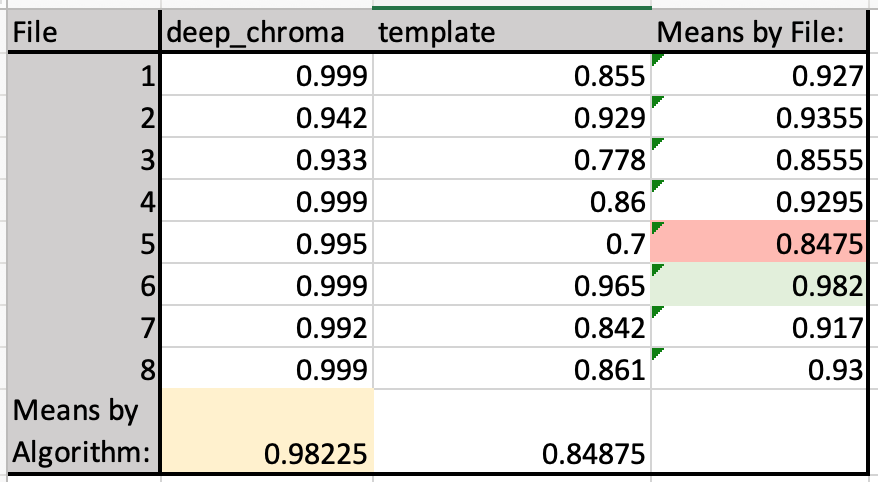


Here is a chart laying out all the data from the 'deep_chroma' and 'template' algorithms for the 8 provided audio files. The better chord recognition technique is DeepChroma. On average, DeepChroma tracks received an value of .982 out of 1.0. That is amazing! The worse algorithm is template matching, receiving a score of .849 out of 1.0. That is still a fairly effective algorithm, in my opinion.

The best track is track 6. The worst is track 5. A second, relatively- low performing track is track 3. 

Trend: I noticed that tracks with more sustained pitches and less percussive sounds performed better. Track 6 is a sustained orchestra with minimal percussive elements and performs well. Meanwhile, tracks 5 and 3 have quick,  percussive sounds (a piano and a banjo, respectively), and tracks 5 and 3 perform worst. 

Trend: Tracks that perform poorly for one algorithm also perform poorly for the other algorithm, relatively speaking. Tracks 3 and 5 exemplify that. There is an exception for track 2. Track 2 performs less well using 'deep_chroma' than than the other tracks. But, track 2 is one of the two best-performing algorithms using 'template.' Track 2 is 'Let It Go' from Frozen, featuring both vocals, instruments, and percussive elements. 

